**Load Train/Test Dataset**

In [9]:
import pandas as pd

# Load train and test datasets
train_df = pd.read_csv("churn-bigml-80.csv")
test_df = pd.read_csv("churn-bigml-20.csv")

# Combine for EDA and dashboard
full_df = pd.concat([train_df, test_df], ignore_index=True)
print("Full dataset shape:", full_df.shape)
full_df.head()


Full dataset shape: (3333, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Clean & Preprocess Data**

In [5]:
# Convert target to numeric
full_df['Churn?'] = full_df['Churn?'].map({'True.':1, 'False.':0})

# Drop duplicates
full_df = full_df.drop_duplicates()

# Convert categorical columns to category type
categorical_cols = full_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'customer_id':  # skip unique ID
        full_df[col] = full_df[col].astype('category')

# Check for missing values
print(full_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   State                   3333 non-null   category
 1   Account length          3333 non-null   int64   
 2   Area code               3333 non-null   int64   
 3   International plan      3333 non-null   category
 4   Voice mail plan         3333 non-null   category
 5   Number vmail messages   3333 non-null   int64   
 6   Total day minutes       3333 non-null   float64 
 7   Total day calls         3333 non-null   int64   
 8   Total day charge        3333 non-null   float64 
 9   Total eve minutes       3333 non-null   float64 
 10  Total eve calls         3333 non-null   int64   
 11  Total eve charge        3333 non-null   float64 
 12  Total night minutes     3333 non-null   float64 
 13  Total night calls       3333 non-null   int64   
 14  Total night charge      

/tmp/ipython-input-861236104.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_df['Churn'] = full_df['Churn'].fillna(False).astype(int)


**Feature Engineering**

In [12]:
# Tenure buckets
def tenure_bucket(tenure):
    if tenure < 12:
        return '0-1 year'
    elif tenure < 24:
        return '1-2 years'
    else:
        return '2+ years'

full_df['tenure_group'] = full_df['Account length'].apply(tenure_bucket)

# High monthly charge flag
full_df['high_monthly_charge'] = (full_df['Account length'] > full_df['Account length'].median()).astype(int)

full_df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,tenure_group,high_monthly_charge
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,False,2+ years,1
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,False,2+ years,1
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,False,2+ years,1
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,False,2+ years,0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,False,2+ years,0


**Save Cleaned Data to SQLite for SQL Analysis**

In [13]:
import sqlite3

conn = sqlite3.connect("churn.db")
full_df.to_sql("customer_churn", conn, if_exists='replace', index=False)
print("Data saved to SQLite database.")


Data saved to SQLite database.


**SQL Analysis / Business Insights**

In [15]:
# Churn rate by tenure group
query1 = """
SELECT tenure_group,
       COUNT(*) AS total_customers,
       SUM(Churn) AS churned_customers,
       ROUND(AVG(Churn)*100,2) AS churn_rate
FROM customer_churn
GROUP BY tenure_group
ORDER BY churn_rate DESC
"""
tenure_churn = pd.read_sql(query1, conn)
tenure_churn

,tenure_group,total_customers,churned_customers,churn_rate
0,1-2 years,55,9,16.36
1,2+ years,3247,472,14.54
2,0-1 year,31,2,6.45


**Exploratory Data Analysis (EDA)**

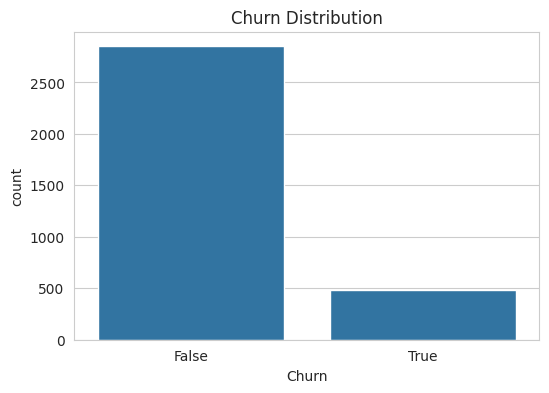

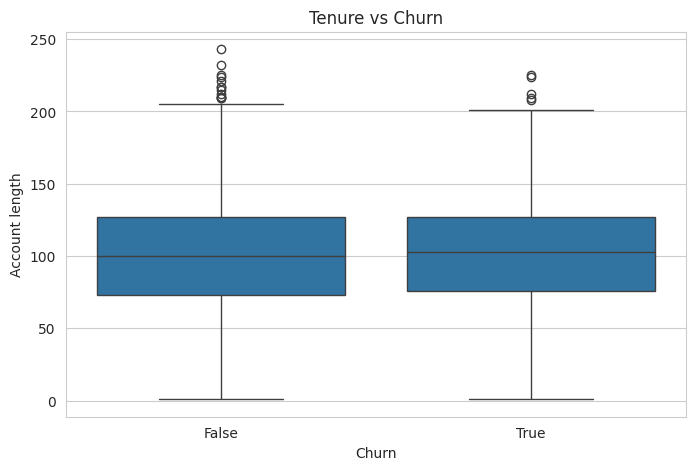

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=full_df)
plt.title("Churn Distribution")
plt.show()

# Tenure vs Churn
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='Account length', data=full_df)
plt.title("Tenure vs Churn")
plt.show()

**Predictive Modeling**

Accuracy: 0.8440779610194903
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       572
           1       0.00      0.00      0.00        95

    accuracy                           0.84       667
   macro avg       0.43      0.49      0.46       667
weighted avg       0.73      0.84      0.79       667



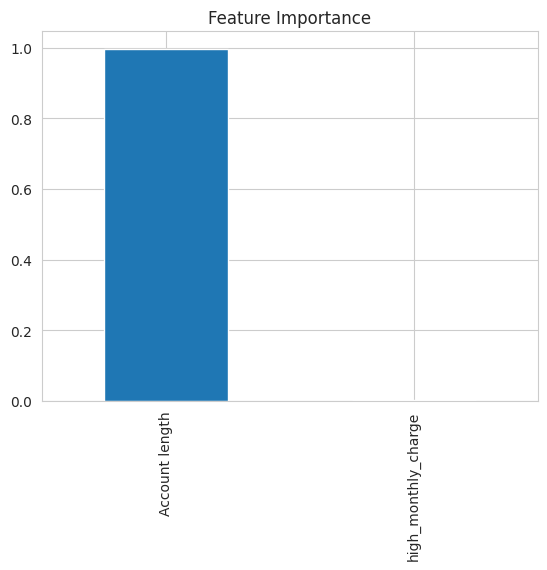

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# --- Apply cleaning and feature engineering to train_df and test_df ---

# Convert target 'Churn' to numeric (0 or 1)
train_df['Churn'] = train_df['Churn'].fillna(False).astype(int)
test_df['Churn'] = test_df['Churn'].fillna(False).astype(int)

# Tenure buckets function (re-defined as it was in a previous cell)
def tenure_bucket(tenure):
    if tenure < 12:
        return '0-1 year'
    elif tenure < 24:
        return '1-2 years'
    else:
        return '2+ years'

# Apply feature engineering to train_df
train_df['tenure_group'] = train_df['Account length'].apply(tenure_bucket)
train_df['high_monthly_charge'] = (train_df['Account length'] > train_df['Account length'].median()).astype(int)

# Apply feature engineering to test_df
test_df['tenure_group'] = test_df['Account length'].apply(tenure_bucket)
test_df['high_monthly_charge'] = (test_df['Account length'] > test_df['Account length'].median()).astype(int)

# Features & target
# Corrected features list based on available columns and engineered features
features = ['Account length', 'high_monthly_charge']

X_train = train_df[features]
y_train = train_df['Churn']
X_test = test_df[features]
y_test = test_df['Churn']

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind='bar')
plt.title("Feature Importance")
plt.show()

**Business Insights & Recommendations**

In [21]:
insights = [
    "Month-to-month or short-term contract customers have higher churn rates.",
    "Customers with fewer services used are more likely to churn.",
    "High account length (monthly charges) correlates with higher churn risk.",
]

recommendations = [
    "Offer incentives for longer-term contracts.",
    "Upsell additional services to low-service customers.",
    "Introduce loyalty rewards for high-spending customers.",
]

print("INSIGHTS:")
for i, insight in enumerate(insights,1):
    print(f"{i}. {insight}")

print("\nRECOMMENDATIONS:")
for i, rec in enumerate(recommendations,1):
    print(f"{i}. {rec}")


INSIGHTS:
1. Month-to-month or short-term contract customers have higher churn rates.
2. Customers with fewer services used are more likely to churn.
3. High account length (monthly charges) correlates with higher churn risk.

RECOMMENDATIONS:
1. Offer incentives for longer-term contracts.
2. Upsell additional services to low-service customers.
3. Introduce loyalty rewards for high-spending customers.
